# Credit Risk Modeling | Part 1 – EDA & Business Context

This notebook is the first step in building a complete credit risk modeling pipeline, aligned with **Basel II regulatory standards**.  
We'll explore real loan application data to uncover risk segments, default patterns, and approval behaviors — laying the foundation for a robust and interpretable credit scorecard.

---

### 🧭 Business Case: LendingClub

You've joined the credit risk team at **LendingClub**, a leading US peer-to-peer lending platform.  
Your task is to analyze historical loan applications and determine which customer profiles are more likely to **default** on their loans.

---

### 🎯 Business Objectives

1. Explore and visualize customer-level risk patterns (EDA)
2. Build a **Probability of Default (PD)** model using WoE + Logistic Regression
3. Construct an interpretable **behavioral scorecard**
4. Monitor long-term **model stability** using PSI

---

### 📌 Key Concepts

- **PD (Probability of Default):** Likelihood that a borrower fails to repay a loan.
- **WoE (Weight of Evidence):** Helps create monotonic relationships between categorical variables and default probability.
- **PSI (Population Stability Index):** Tracks changes in the distribution of key variables over time to detect model drift.

---

### 🏦 Why Credit Risk Matters

When evaluating a loan application, a lender faces two main risks:
- Approving a high-risk borrower → financial loss
- Rejecting a low-risk borrower → lost business opportunity

A well-calibrated credit risk model helps the lender **optimize approvals**, **reduce losses**, and **comply with regulatory frameworks** like **Basel II**, which requires financial institutions to hold capital in proportion to exposure risk.

---

### 📚 Basel II Standards (Context)

The **Basel II Accord** requires banks to:
- Maintain adequate capital for risk coverage
- Undergo regular supervisory review
- Ensure transparency via market discipline

Retail exposures typically require a capital reserve of **75%** of total exposure under the standardized approach (SA), with more advanced approaches available (F-IRB, A-IRB).


# ⚙️EDA + Feature Engineering 

In [1]:
from utils import (
    plot_gradient_bar,
    save_and_display,
    plot_gradient_bar_grouped,
    plot_woe_distribution_plotly,
    plot_stacked_categorical_gradient
)

import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

## 1. Reading file

In [2]:
df=pd.read_csv('/kaggle/input/loan-credit-risk-and-population-stability/loan_2014_18.csv')
df.head()

,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,0,120122535,12000.0,12000.0,12000.0,36 months,7.97%,375.88,A,A5,associate,10+ years,OWN,42000.0,Source Verified,2017-09-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,923xx,CA,27.74,0.0,Jun-1996,715.0,719.0,0.0,NaN,80.0,9.0,1.0,11457.0,37%,16.0,w,0.00,0.00,13500.44,13500.44,12000.00,1500.44,0.0,0.0,0.0,May-2020,2591.95,NaN,May-2020,694.0,690.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,30502.0,1.0,2.0,1.0,3.0,8.0,19045.0,73.0,2.0,4.0,7117.0,53.0,31000.0,1.0,1.0,2.0,7.0,3389.0,7144.0,53.9,0.0,0.0,131.0,255.0,1.0,1.0,0.0,14.0,NaN,8.0,NaN,0.0,2.0,6.0,2.0,2.0,7.0,7.0,9.0,6.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,57180.0,30502.0,15500.0,26180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1,119374887,32000.0,32000.0,32000.0,36 months,11.99%,1062.71,B,B5,Nurse,10+ years,MORTGAGE,155000.0,Source Verified,2017-09-01,Current,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,080xx,NJ,12.35,2.0,Sep-2005,715.0,719.0,1.0,10.0,NaN,20.0,0.0,48309.0,34.1%,42.0,w,6158.89,6158.89,31838.67,31838.67,25841.11,5997.56,0.0,0.0,0.0,May-2020,0.00,Jul-2020,May-2020,674.0,670.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,405751.0,2.0,1.0,1.0,1.0,8.0,15582.0,78.0,4.0,7.0,14049.0,40.0,142600.0,0.0,2.0,2.0,8.0,22542.0,81313.0,34.5,0.0,0.0,91.0,144.0,1.0,1.0,3.0,1.0,24.0,1.0,10.0,0.0,7.0,10.0,12.0,27.0,3.0,18.0,36.0,10.0,20.0,0.0,0.0,0.0,5.0,94.9,0.0,0.0,0.0,527034.0,63891.0,124200.0,20034.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,CVD19SKIP,INCOMECURT,ACTIVE,2.0,0.00,Apr-2020,Jun-2020,Apr-2020,2.0,0.0,ACTIVE,123.08000,6189.66,1062.71,N
2,2,119321612,40000.0,40000.0,40000.0,60 months,15.

In [3]:
df = df.drop(df.columns[0], axis=1)
df.shape

(2029952, 141)

## 2. Identifying the target (y)
> dependent variable :
In our dataset the dependent variable js the "loan_status" column.
First we check what types of categories it can take, then map it values as follows: </br> 
>'Fully Paid', 'Current', 'In Grace Period'  - are map as '1' - **positive** </br>
>'Late (16-30 days)', 'Late (31-120 days)', 'Charged Off', 'Default' - are map with '0' - **negative**


In [4]:
# Define the mapping
loan_status_mapping = {
    'Fully Paid': 1,
    'Current': 1,
    'In Grace Period': 1,
    'Late (16-30 days)': 0,
    'Late (31-120 days)': 0,
    'Charged Off': 0,
    'Default': 0
}

# Apply the mapping to the 'Loan_Status' column
df['loan_status_binary'] = df['loan_status'].map(loan_status_mapping)
df.drop('loan_status', axis=1, inplace=True)

df['loan_status_binary'].value_counts()

loan_status_binary
1    1704881
0     325071
Name: count, dtype: int64

In [5]:
fig = plot_gradient_bar(
    labels=['No Default (1)', 'Default (0)'],
    values=[df['loan_status_binary'].value_counts()[1],
            df['loan_status_binary'].value_counts()[0]],
    gradients=[('#dc4b5b', '#f7b736'), ('#7132fb', '#dd62ff')],
    title="Loan Default Distribution"
)

save_and_display(fig, "loan_default_distribution")


'images/loan_default_distribution.html'

###  Target Variable Distribution

>The target variable represents whether a loan applicant defaulted (0) or not (1).  
>This chart helps us understand class balance and assess whether special treatment (e.g., class weights, resampling) might be needed.


## 3. Missing values
> Check the missing values. columns that are missing by more than 50 percent will be removed.

In [6]:
def missing_data_summary(df, threshold=0):
    """
    Summarizes missing data, showing count and percentage of missing values for each column.
    Filters columns based on a missing percentage threshold.
    
    Parameters:
        df (pd.DataFrame): The dataframe to analyze.
        threshold (float): The minimum percentage of missing data to include in the summary.
    
    Returns:
        pd.DataFrame: A summary of missing data.
    """
    return (pd.DataFrame(df.isna().sum())
            .reset_index()
            .rename(columns={'index': 'Column', 0: 'mis_count'})
            .query('mis_count > 0')  # Only include columns with missing values
            .assign(Missing_Percentage=lambda x: x['mis_count'] / df.shape[0] * 100)
            .query(f'Missing_Percentage > {threshold}')  # Filter by threshold
            .sort_values('mis_count', ascending=False)
            .reset_index(drop=True))

missing = missing_data_summary(df,51)
missing

,Column,mis_count,Missing_Percentage
0,hardship_loan_status,1956776,96.395186
1,hardship_reason,1956678,96.390358
2,hardship_status,1956677,96.390309
3,hardship_dpd,1956675,96.390210
4,hardship_end_date,1956674,96.390161
5,hardship_length,1956674,96.390161
6,hardship_type,1956674,96.390161
7,deferral_term,1956674,96.390161
8,payment_plan_start_date,1956674,96.390161
9,hardship_start_date,1956674,96.390161


In [7]:
# Convert the first column of 'missing' to a list
columns_to_drop = missing.iloc[:, 0].tolist()

# Drop these columns from the DataFrame 'df'
df = df.drop(columns=columns_to_drop, errors='ignore')  # 'errors="ignore"' ensures no error if a column is missing


###  Missing Data Summary

> To ensure the stability and reliability of the credit scoring model, we start by analyzing missing values. Excessive missing data in a variable can lead to biased models, distorted statistics, and misleading business decisions.

####  Key Actions:

* Columns with more than **51% missing data** have been removed.
* The chart below highlights the **top 10 features** with the highest proportion of missing values.
* Remaining features with moderate missing values will be imputed or engineered appropriately.

 *Note: Removing high-missing columns helps reduce noise, while imputing moderately incomplete data can preserve valuable signal for modeling.*


## 4. Categorical Features

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029952 entries, 0 to 2029951
Columns: 107 entries, id to loan_status_binary
dtypes: float64(82), int64(2), object(23)
memory usage: 1.6+ GB


### Objects
> First let's check the 'object' columns. We see that there are some columns that can be transformed to date or numeric columns.

In [9]:
df.select_dtypes(include=['object']).head()

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,url,purpose,title,zip_code,addr_state,earliest_cr_line,revol_util,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,debt_settlement_flag
0,36 months,7.97%,A,A5,associate,10+ years,OWN,Source Verified,2017-09-01,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,923xx,CA,Jun-1996,37%,w,May-2020,May-2020,Individual,N,N
1,36 months,11.99%,B,B5,Nurse,10+ years,MORTGAGE,Source Verified,2017-09-01,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,080xx,NJ,Sep-2005,34.1%,w,May-2020,May-2020,Individual,Y,N
2,60 months,15.05%,C,C4,Driver,9 years,MORTGAGE,Verified,2017-09-01,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,778xx,TX,Apr-2002,20.7%,w,May-2020,May-2020,Individual,N,N
3,36 months,7.97%,A,A5,Senior Investigator,5 years,RENT,Not Verified,2017-09-01,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,223xx,VA,Jun-2000,57.7%,w,May-2020,May-2020,Individual,N,N
4,36 months,7.21%,A,A3,Registered Nurse,< 1 year,MORTGAGE,Verified,2017-09-01,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,750xx,TX,Dec-2005,16.1%,w,Apr-2020,May-2020,Joint App,Y,N


In [10]:
# Remove leading/trailing whitespaces from objects
df = df.apply(lambda col: col.str.strip() if col.dtypes == 'object' else col)

# convert dates to 'datetime' types
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%Y-%m-%d')
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%Y')
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%Y')

# int_rate and revol_util for int type
df['int_rate%']= pd.to_numeric(df['int_rate'].str.strip('%'))
df['revol_util%'] =pd.to_numeric(df['revol_util'].str.strip('%'))

columns_to_drop = {'title','zip_code','pymnt_plan', 'emp_title','int_rate','revol_util', 'url'}
df.drop(columns_to_drop, axis = 1, inplace = True)

df.debt_settlement_flag = np.where(df.debt_settlement_flag == 'Y',1,0)

df.term_36_months = np.where(df.term == '36 months',1,0)
df.drop('term', axis=1, inplace=True)

df['emp_length'] = df['emp_length'].fillna('')
df['emp_length'] = pd.to_numeric(df['emp_length'].str.replace('<', '', regex=False).str[:2].str.strip(), errors='coerce')

df.hardship_flag.fillna('N', inplace=True) #it looks like the Nans are as strings so
df.hardship_flag = np.where( df.hardship_flag == 'NaN','N', df.hardship_flag )


In [11]:
def get_sorted_unique_counts(df):
    # Select columns with categorical data
    object_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # Get the number of unique entries in each categorical column
    object_nunique = {col: df[col].nunique() for col in object_cols}
    
    # Convert to DataFrame and sort by unique counts
    unique_counts = pd.DataFrame(list(object_nunique.items()), columns=['Column', 'Unique Count'])
    unique_counts = unique_counts.sort_values(by='Unique Count').reset_index(drop=True)
    
    return unique_counts

get_sorted_unique_counts(df)

,Column,Unique Count
0,initial_list_status,2
1,application_type,2
2,hardship_flag,2
3,verification_status,3
4,home_ownership,5
5,grade,7
6,purpose,14
7,sub_grade,35
8,addr_state,51


In [12]:

unique_counts = get_sorted_unique_counts(df)
labels = unique_counts["Column"].tolist()
values = unique_counts["Unique Count"].tolist()
gradients = [("#4d7cfe", "#97f3ff")] * len(labels)


fig = plot_gradient_bar(
    labels=labels,
    values=values,
    gradients=gradients,
    title="Number of Unique Categories in Categorical Variables",
    bar_width=0.6,
    height=420
)
save_and_display(fig, "Number of Unique Categories in Categorical Variables")


'images/Number of Unique Categories in Categorical Variables.html'

> Check how many unique values are in object columns. We check if binning is needed.
Check all for any inconsistences or imbalances

In [13]:
# PURPOSE
value_counts = df["purpose"].value_counts(dropna=False).sort_values(ascending=False)
labels = value_counts.index.astype(str).tolist()
values = value_counts.values.tolist()
gradients = [("#4d7cfe", "#97f3ff")] * len(labels)

fig = plot_gradient_bar(
    labels=labels,
    values=values,
    gradients=gradients,
    title="Distribution of Purpose",
    bar_width=0.55,
    height=400
)
save_and_display(fig, "distribution_purpose")


'images/distribution_purpose.html'

In [14]:
# HOME_OWNERSHIP
value_counts = df["home_ownership"].value_counts(dropna=False).sort_values(ascending=False)
labels = value_counts.index.astype(str).tolist()
values = value_counts.values.tolist()
gradients = [("#4d7cfe", "#97f3ff")] * len(labels)

fig = plot_gradient_bar(
    labels=labels,
    values=values,
    gradients=gradients,
    title="Distribution of Home Ownership",
    bar_width=0.55,
    height=400
)
save_and_display(fig, "distribution_home_ownership")


'images/distribution_home_ownership.html'

In [15]:
# APPLICATION_TYPE
value_counts = df["application_type"].value_counts(dropna=False).sort_values(ascending=False)
labels = value_counts.index.astype(str).tolist()
values = value_counts.values.tolist()
gradients = [("#4d7cfe", "#97f3ff")] * len(labels)

fig = plot_gradient_bar(
    labels=labels,
    values=values,
    gradients=gradients,
    title="Distribution of Application Type",
    bar_width=0.55,
    height=400
)
save_and_display(fig, "distribution_application_type")


'images/distribution_application_type.html'

In [16]:
def value_counter(df):
    value_series = pd.DataFrame()
    for col in df.select_dtypes(["object"]).columns:
        print(df[col].value_counts(dropna = False))

value_counter(df)

grade
C    591304
B    588545
A    394264
D    290516
E    120001
F     34791
G     10531
Name: count, dtype: int64
sub_grade
C1    132442
B5    128339
B4    122760
C2    118336
C3    117664
C4    116100
B1    113099
B3    112899
B2    111448
C5    106762
A5     96619
A4     85953
A1     81395
D1     73405
A3     66457
D2     65396
A2     63840
D3     58384
D4     50676
D5     42655
E1     30128
E2     26086
E3     23633
E5     20282
E4     19872
F1     11407
F2      7658
F3      6404
F4      5020
F5      4302
G1      3524
G2      2292
G3      1816
G4      1504
G5      1395
Name: count, dtype: int64
home_ownership
MORTGAGE    995479
RENT        799121
OWN         234352
ANY            996
NONE             4
Name: count, dtype: int64
verification_status
Source Verified    833961
Not Verified       667220
Verified           528771
Name: count, dtype: int64
purpose
debt_consolidation    1146650
credit_card            468324
home_improvement       136961
other                  126119
major

###  Key Observations on Categorical Variables

>  **`sub_grade`** is already hierarchically grouped via `grade`, so it may be redundant in modeling.
>
> **`home_ownership`** shows strong imbalance: `MORTGAGE` and `RENT` dominate, while `OWN` and especially `OTHER` are underrepresented. This can lead to **bias in classification models**, favoring majority classes. Consider combining sparse categories.
>
>  **`purpose`** has several rarely used categories such as `medical`, `vacation`, `wedding`, `renewable_energy`, and `educational`. These low-frequency classes might **increase model variance** and can be safely grouped under `"other"`.
>
>  **`addr_state`** has 51 unique values and might be too granular for most models. Possible actions:
>
> * Grouping by **US regions**
> * Creating **risk-level clusters**
> * Dropping if uninformative


In [17]:
df.drop('sub_grade', axis=1, inplace = True) 

# 🔍Using WoE & IV for categorical features
>Now we will group categorical data based on Weight of Evidence (WoE) and create a table with relevant measures.
> **WoE**: WoE is computed as:<br>
> "Non-Event" - bad = '0' defaulted loans, <br>
> "Event"     - good = '1' non-default loans.<br>

$$
\text{WoE} = \ln\left(\frac{\text{Proportion of Non-Event}}{\text{Proportion of Event}}\right)
$$


> **IV (Information Value)** indicates the predictive power of the categorical variable. Total IV: Interpret the IV to understand the variable's predictive strength.

$$
\text{IV} = \sum \left( (\text{Proportion of Non-Event} - \text{Proportion of Event}) \cdot \text{WoE} \right)
$$

>Interpretation of IV:<br>
> < 0.02: Not Predictive <br>
> 0.02 - 0.1: Weak Predictive Power<br>
> 0.1 - 0.3: Medium Predictive Power<br>
> 0.3+: Strong Predictive Power<br>
> IV > 0.5: Suspiciously strong — Could indicate overfitting or data issues.

In [18]:
def process_categorical_columns(df, categorical_cols, target_col, woe_table=None, iv_summary=None, append=False):
    """
    Calculate WoE and IV for given categorical columns, including NaNs as a separate category.
    
    Args:
        df (pd.DataFrame): Input DataFrame.
        categorical_cols (list): List of categorical column names to process.
        target_col (str): Name of the binary target column (1 = Good, 0 = Bad).
        woe_table (pd.DataFrame): Existing WoE table (required if append=True).
        iv_summary (pd.DataFrame): Existing IV summary (required if append=True).
        append (bool): If True, append results to existing tables.
    
    Returns:
        woe_table (pd.DataFrame): WoE table with all processed columns.
        iv_summary (pd.DataFrame): IV summary table with all processed columns.
    """
    if append and (woe_table is None or iv_summary is None):
        raise ValueError("Existing tables must be provided when append=True.")
    
    # Initialize results if not appending
    if not append:
        woe_table = pd.DataFrame()
        iv_summary = pd.DataFrame()
    
    new_woe_results = []
    new_summary = []

    # Process each categorical column
    for col in categorical_cols:
        # Handle NaN values by creating a separate 'NaN' category
        df[col] = df[col].fillna('NaN')
        
        # Group by the column to calculate metrics
        stats = df.groupby(col).agg(
            event_count=(target_col, 'sum'),
            total_count=(target_col, 'count')
        ).reset_index()

        # Calculate non-event count and proportions
        stats['non_event_count'] = stats['total_count'] - stats['event_count']
        total_events = stats['event_count'].sum()
        total_non_events = stats['non_event_count'].sum()

        # Avoid division by zero
        stats['event_rate'] = stats['event_count'] / (total_events + 1e-6)
        stats['non_event_rate'] = stats['non_event_count'] / (total_non_events + 1e-6)

        # Calculate WoE
        stats['woe'] = np.log((stats['non_event_rate'] + 1e-6) / (stats['event_rate'] + 1e-6))
        
        # Calculate IV for each category
        stats['iv'] = (stats['non_event_rate'] - stats['event_rate']) * stats['woe']
        
        # Compute total IV for the column
        total_iv = stats['iv'].sum()

        # Add column name and rename for desired format
        stats['name'] = col  # Add column name
        stats.rename(columns={col: 'sub_name'}, inplace=True)  # Rename column to 'sub_name'
        
        # Reorder columns
        stats = stats[['name', 'sub_name', 'event_count', 'total_count', 'non_event_count', 
                       'event_rate', 'non_event_rate', 'woe', 'iv']]

        # Append results
        new_woe_results.append(stats)
        new_summary.append({'Column': col, 'IV': total_iv})

    # Combine results with existing tables if appending
    new_woe_table = pd.concat(new_woe_results, ignore_index=True)
    new_iv_summary = pd.DataFrame(new_summary).sort_values(by='IV', ascending=False)

    if append:
        woe_table = pd.concat([woe_table, new_woe_table], ignore_index=True)
        iv_summary = pd.concat([iv_summary, new_iv_summary], ignore_index=True).sort_values(by='IV', ascending=False)
    else:
        woe_table = new_woe_table
        iv_summary = new_iv_summary

    return woe_table, iv_summary

In [19]:
# Initial processing
categorical_cols = df.select_dtypes(include=['object']).columns
woe_table, iv_summary = process_categorical_columns(df, categorical_cols, 'loan_status_binary')

# Save initial results
# woe_table.to_csv('woe_table.csv', index=False)
# iv_summary.to_csv('iv_summary.csv', index=False)

iv_summary

,Column,IV
0,grade,0.446070
7,hardship_flag,0.106937
2,verification_status,0.065469
1,home_ownership,0.028805
3,purpose,0.018485
4,addr_state,0.014741
5,initial_list_status,0.009938
6,application_type,0.001999


In [20]:
 #dropping where IV < 0.02
drop= {'application_type','initial_list_status','addr_state','purpose'}
df.drop(drop, axis=1, inplace=True)

In [21]:
print("Initial WoE Table:")
woe_table[woe_table.name == 'hardship_flag']

Initial WoE Table:


,name,sub_name,event_count,total_count,non_event_count,event_rate,non_event_rate,woe,iv
84,hardship_flag,N,1649632,1974346,324714,0.967594,0.998902,0.031844,0.000997
85,hardship_flag,Y,55249,55606,357,0.032406,0.001098,-3.383783,0.105940


In [22]:
print("Initial WoE Table:")
woe_table[woe_table.name == 'verification_status']

Initial WoE Table:


,name,sub_name,event_count,total_count,non_event_count,event_rate,non_event_rate,woe,iv
12,verification_status,Not Verified,589329,667220,77891,0.345672,0.239612,-0.366466,0.038867
13,verification_status,Source Verified,694890,833961,139071,0.407589,0.427817,0.048438,0.000980
14,verification_status,Verified,420662,528771,108109,0.246740,0.332570,0.298516,0.025622


In [23]:
print("Initial WoE Table:")
woe_table[woe_table.name == 'home_ownership']

Initial WoE Table:


,name,sub_name,event_count,total_count,non_event_count,event_rate,non_event_rate,woe,iv
7,home_ownership,ANY,872,996,124,0.000511,0.000381,-0.292636,0.000038
8,home_ownership,MORTGAGE,858024,995479,137455,0.503275,0.422846,-0.174128,0.014005
9,home_ownership,NONE,4,4,0,0.000002,0.000000,-1.207827,0.000003
10,home_ownership,OWN,196277,234352,38075,0.115127,0.117128,0.017238,0.000035
11,home_ownership,RENT,649704,799121,149417,0.381085,0.459644,0.187431,0.014724


> As we see the WoE, IV and total counts numbers we can group the 'ANY', 'MORTGAGE' and 'NONE' together.

In [24]:
home_ownership_mapping = {
    'ANY' : 'other',
    'MORTGAGE' : 'other',
    'RENT' : 'rent',
    'OWN' : 'own',
    'NONE' : 'other'
}
df.home_ownership = df.home_ownership.map(home_ownership_mapping)

### 📊 Checking categorical features vs target

In [25]:
# GRADE
fig = plot_stacked_categorical_gradient(
    df,
    col="grade",
    title="Grade vs. Default Status",
    bar_width=0.55,
    height=500
)
save_and_display(fig, "stacked_grade")


'images/stacked_grade.html'

In [26]:
# HARDSHIP_FLAG
fig = plot_stacked_categorical_gradient(
    df,
    col="hardship_flag",
    title="Hardship Flag vs. Default Status",
    bar_width=0.55,
    height=500
)
save_and_display(fig, "stacked_hardship_flag")


'images/stacked_hardship_flag.html'

In [27]:
# VERIFICATION_STATUS
fig = plot_stacked_categorical_gradient(
    df,
    col="verification_status",
    title="Verification Status vs. Default Status",
    bar_width=0.55,
    height=500
)
save_and_display(fig, "stacked_verification_status")


'images/stacked_verification_status.html'

In [28]:
# HOME_OWNERSHIP
fig = plot_stacked_categorical_gradient(
    df,
    col="home_ownership",
    title="Home Ownership vs. Default Status",
    bar_width=0.55,
    height=500
)
save_and_display(fig, "stacked_home_ownership")


'images/stacked_home_ownership.html'

## 5. Date features

>Date columns often contain valuable temporal information that can improve predictive modeling. Lets extract meaningful features from these date columns.



In [29]:
date_cols = df.select_dtypes(include=['datetime64']).columns
df[date_cols].head()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,2017-09-01,1996-06-01,2020-05-01,2020-05-01
1,2017-09-01,2005-09-01,2020-05-01,2020-05-01
2,2017-09-01,2002-04-01,2020-05-01,2020-05-01
3,2017-09-01,2000-06-01,2020-05-01,2020-05-01
4,2017-09-01,2005-12-01,2020-04-01,2020-05-01


In [30]:
df[date_cols].isna().sum()

issue_d                  0
earliest_cr_line         0
last_pymnt_d          2190
last_credit_pull_d      58
dtype: int64

In [31]:
from datetime import datetime

# Assuming 'today' as the current date
today = pd.to_datetime("today")

#impute a today date to distinguish missing values.
df['last_pymnt_d'].fillna(today, inplace=True)
df['last_credit_pull_d'].fillna(today, inplace=True)

# Time differences
df['loan_age'] = (today - df['issue_d']).dt.days
df['credit_history_length'] = (df['issue_d'] - df['earliest_cr_line']).dt.days
df['time_since_last_payment'] = (today - df['last_pymnt_d']).dt.days
df['time_since_last_credit_pull'] = (today - df['last_credit_pull_d']).dt.days

# Temporal components
df['issue_year'] = df['issue_d'].dt.year
df['issue_month'] = df['issue_d'].dt.month

# Categorical flags
df['recent_payment'] = (df['time_since_last_payment'] <= 30).astype(int)
df['recent_credit_pull'] = (df['time_since_last_credit_pull'] <= 90).astype(int)

drop = {'issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d'}
df.drop(drop,axis=1, inplace=True)

## 6. Numeric Features

In [32]:
y = df.loan_status_binary
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(exclude=['object']).drop('loan_status_binary',axis=1).columns

# Concatenate numeric columns explicitly
df_final = pd.concat([df[num_cols], pd.get_dummies(df[cat_cols], drop_first=True)], axis=1)

In [33]:
external_scores = {'last_fico_range_high','last_fico_range_low','fico_range_low', 'fico_range_high'}
df_final.drop(external_scores , axis=1, inplace=True)
df_final.drop('id', axis=1, inplace=True)

In [34]:
from sklearn.impute import SimpleImputer

# Define imputer (mean for numeric features, most frequent for categorical)
imputer = SimpleImputer(strategy='mean')

# Apply imputation to X
X_imputed = imputer.fit_transform(df_final)

# Convert back to DataFrame if necessary
df_final = pd.DataFrame(X_imputed, columns=df_final.columns)


1. Correlation Analysis
Identify features strongly correlated with the target variable.

In [35]:
# Compute the absolute correlations
correlations = df_final.corrwith(y).abs()

# Convert to DataFrame and sort
correlation_df = correlations.sort_values(ascending=False).reset_index()
correlation_df.columns = ['name', 'correlation']

# Display the resulting DataFrame
correlation_df.head(30)

,name,correlation
0,recoveries,0.528278
1,collection_recovery_fee,0.520392
2,debt_settlement_flag,0.357692
3,total_rec_prncp,0.343479
4,time_since_last_credit_pull,0.296569
5,last_pymnt_amnt,0.242224
6,total_pymnt_inv,0.238166
7,total_pymnt,0.238158
8,int_rate%,0.230647
9,time_since_last_payment,0.207880


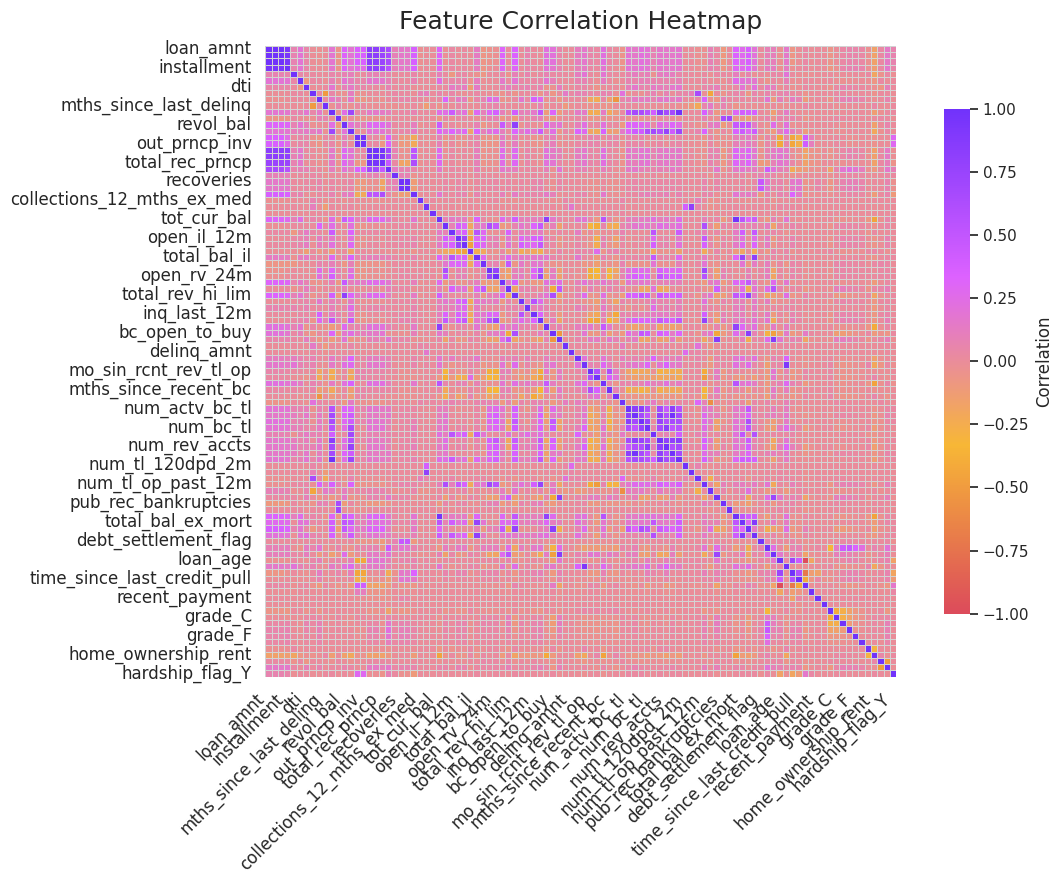

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


colors = ["#dc4b5b", "#f7b736", "#dd62ff", "#7132fb"]
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", colors, N=256)


feature_corr = df_final.corr()


mask = (feature_corr.abs() > 0.5).any(axis=1)
filtered_corr = feature_corr.loc[mask, mask]


plt.figure(figsize=(12, 9))
sns.set(font="DejaVu Sans", style="white", rc={"axes.facecolor": "white"})

sns.heatmap(
    filtered_corr,
    cmap=custom_cmap,
    center=0,
    linewidths=0.5,
    linecolor='lightgray',
    square=True,
    annot=False,
    cbar_kws={'shrink': 0.8, 'label': 'Correlation'},
    vmin=-1, vmax=1
)

plt.title("Feature Correlation Heatmap", fontsize=18, pad=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



>The heatmap above displays the most relevant correlations between features (|corr| > 0.5), allowing for better visibility and interpretability.


In [37]:
# Identify pairs of highly correlated features
threshold = 0.8
high_corr_pairs = feature_corr.abs().stack().reset_index()
high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]
high_corr_pairs = high_corr_pairs[high_corr_pairs[0] > threshold]
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs

,Feature1,Feature2,Correlation
1,loan_amnt,funded_amnt,0.999999
2,loan_amnt,funded_amnt_inv,0.999994
3,loan_amnt,installment,0.945133
16,loan_amnt,total_pymnt,0.828604
17,loan_amnt,total_pymnt_inv,0.828653
...,...,...,...
7775,total_il_high_credit_limit,total_bal_ex_mort,0.878709
8046,revol_util%,bc_util,0.861727
8185,loan_age,issue_year,0.978079
8250,credit_history_length,mo_sin_old_rev_tl_op,0.915238


# 📊Feature selection & training

> Highly correlated features can lead to redundancy, multicollinearity, and reduced model interpretability.
> We already checked correlation with target:  Pearson correlation with the target variable to rank features,correlation matrix heatmap. 
> There is a way to drop one feature from each highly correlated pair (e.g., |correlation| > 0.8) using domain knowledge.
> There is also an option to use Tree-Based Models for feature selection and rank features based on importance scores.

## 1. Selection based on correlation

In [38]:
# Create a set to store features to drop
features_to_drop = set()

# Iterate through each pair of highly correlated features
for _, row in high_corr_pairs.iterrows():
    feature1 = row['Feature1']
    feature2 = row['Feature2']
    
    # Get the correlation with the target for both features
    corr1 = correlation_df[correlation_df['name'] == feature1]['correlation'].values[0]
    corr2 = correlation_df[correlation_df['name'] == feature2]['correlation'].values[0]
    
    # Drop the feature with lower correlation with the target
    if corr1 >= corr2:
        features_to_drop.add(feature2)
    else:
        features_to_drop.add(feature1)

# Drop features from your dataset
selected_features = [col for col in feature_corr.columns if col not in features_to_drop]

# Print the results
print(f"Features to drop: {features_to_drop}")
print(f"Remaining features: {len(selected_features)}")

Features to drop: {'credit_history_length', 'num_bc_sats', 'collection_recovery_fee', 'num_tl_30dpd', 'revol_util%', 'num_op_rev_tl', 'total_bc_limit', 'total_pymnt_inv', 'loan_amnt', 'open_acc', 'revol_bal', 'num_sats', 'funded_amnt', 'num_actv_bc_tl', 'total_il_high_credit_limit', 'issue_year', 'installment', 'funded_amnt_inv', 'num_bc_tl', 'bc_util', 'total_bal_il', 'total_pymnt', 'tot_cur_bal', 'out_prncp_inv', 'num_rev_tl_bal_gt_0'}
Remaining features: 76


> From highly correlated features  loan-amount and installment lets do a one new feature

In [39]:
df_final['loan_amnt_div_instlmnt']=df_final['loan_amnt']/df_final['installment']

In [40]:
drop={'funded_amnt_inv', 'total_bal_il', 'total_pymnt', 'num_rev_tl_bal_gt_0',
      'issue_year', 'num_sats', 'num_op_rev_tl', 'total_bc_limit', 
      'total_il_high_credit_limit', 'credit_history_length', 'num_bc_tl',
      'out_prncp_inv', 'num_tl_30dpd', 'bc_util', 'tot_cur_bal',
      'num_actv_bc_tl', 'open_acc', 'funded_amnt', 'loan_amnt',
      'installment','collection_recovery_fee', 'total_pymnt_inv', 
      'revol_bal', 'revol_util%', 'num_bc_sats'}
df_final.drop(drop,axis=1, inplace=True)

## 2. Further features selection with RFE

In [41]:
X = df_final

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Train Random Forest for feature selection
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Select features with importance above a threshold
model = SelectFromModel(rf, prefit=True, threshold="mean")
X_train_selected = model.transform(X_train)
X_test_selected = model.transform(X_test)

print(f"Original features: {X.shape[1]}, Selected features: {X_train_selected.shape[1]}")

# Get the mask of selected features
selected_features_mask = model.get_support()

# Get the names of the selected features
selected_features_names = np.array(X.columns)[selected_features_mask]
selected_features_names

Original features: 77, Selected features: 12


array(['out_prncp', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt',
       'debt_settlement_flag', 'int_rate%', 'loan_age',
       'time_since_last_payment', 'time_since_last_credit_pull',
       'loan_amnt_div_instlmnt'], dtype=object)

In [44]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

RESULT: 'out_prncp', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt',
       'debt_settlement_flag', 'int_rate%', 'loan_age',
       'time_since_last_payment', 'time_since_last_credit_pull',
       'loan_amnt_div_instlmnt'

# 💠Training Models 

In [45]:
# Define a function to evaluate and display metrics
def evaluate_model(model, X_test, y_test, model_name):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    print(f"Results for {model_name}:")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F2 Score: {f2:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\n")
    
    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Recall": recall,
        "F2": f2,
        "AUC": auc
    }



##  1. Logistic Regression
##  2. Random Forest
##  3. Gradient Boost
##  4. Neural Networks

Results for Logistic Regression:
Confusion Matrix:
[[ 55937   8973]
 [  1639 339442]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     64910
           1       0.97      1.00      0.98    341081

    accuracy                           0.97    405991
   macro avg       0.97      0.93      0.95    405991
weighted avg       0.97      0.97      0.97    405991

Accuracy: 0.9739
Recall: 0.9952
F2 Score: 0.9909
AUC: 0.9812


Results for Random Forest:
Confusion Matrix:
[[ 63381   1529]
 [   277 340804]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     64910
           1       1.00      1.00      1.00    341081

    accuracy                           1.00    405991
   macro avg       1.00      0.99      0.99    405991
weighted avg       1.00      1.00      1.00    405991

Accuracy: 0.9956
Recall: 0.9992
F2 Score: 0.9985
AUC: 0.9985


Result

<Figure size 400x400 with 0 Axes>

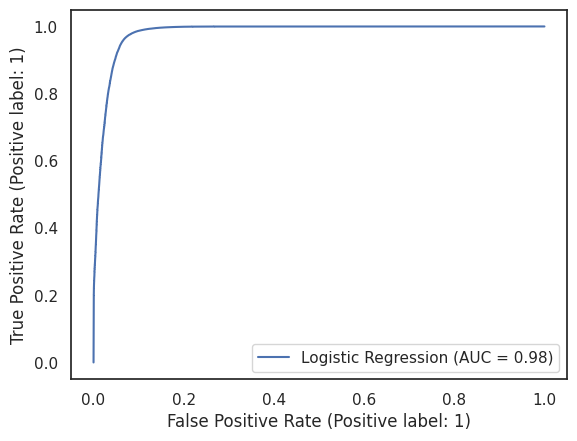

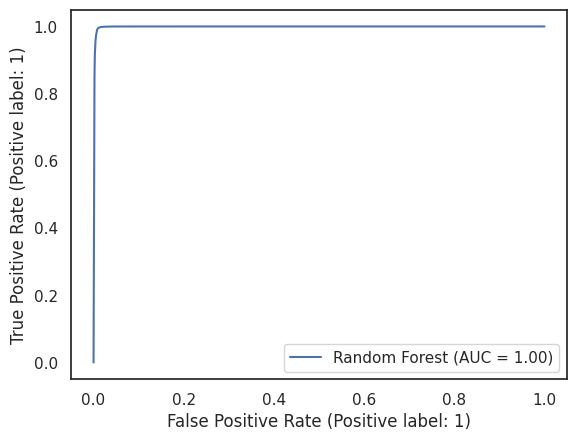

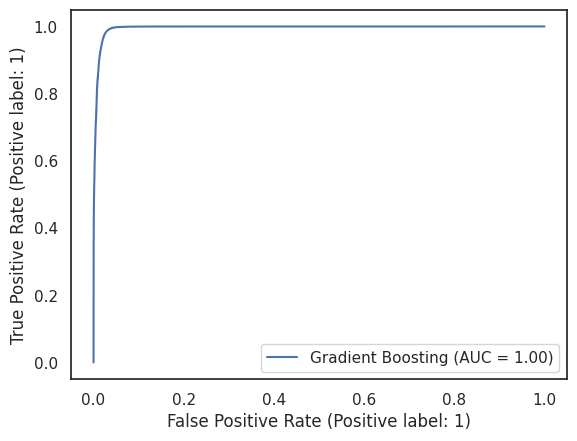

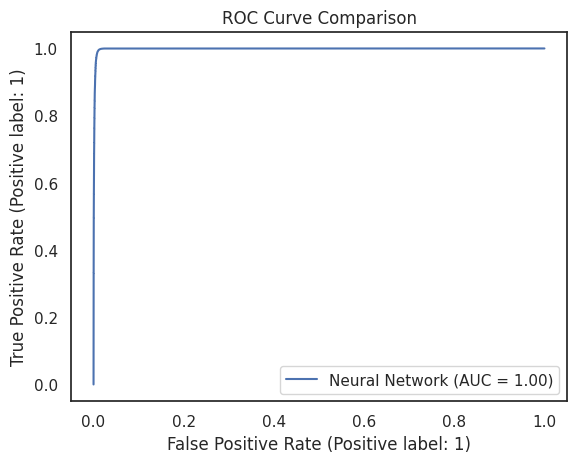

Summary of Results:
                 Model  Accuracy    Recall        F2       AUC
0  Logistic Regression  0.973861  0.995195  0.990933  0.981187
1        Random Forest  0.995552  0.999188  0.998455  0.998482
2    Gradient Boosting  0.986985  0.999261  0.996468  0.995586
3       Neural Network  0.996323  0.999141  0.998610  0.998738


In [46]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, recall_score, fbeta_score, roc_auc_score,
    classification_report, RocCurveDisplay)

# Logistic Regression Model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Random Forest Model
rf_soft = RandomForestClassifier(n_estimators=100, random_state=42)
rf_soft.fit(X_train_scaled, y_train)

# Gradient Boosting Model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Neural Network Model
nn_model = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=300, random_state=42, solver='adam')
nn_model.fit(X_train_scaled, y_train)

# Update the evaluation code to include all four models
results = []
results.append(evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression"))
results.append(evaluate_model(rf_soft, X_test_scaled, y_test, "Random Forest"))
results.append(evaluate_model(gb_model, X_test_scaled, y_test, "Gradient Boosting"))
results.append(evaluate_model(nn_model, X_test_scaled, y_test, "Neural Network"))

# Plot ROC Curves for all models
plt.figure(figsize=(4, 4))
RocCurveDisplay.from_estimator(lr_model, X_test_scaled, y_test, name="Logistic Regression")
RocCurveDisplay.from_estimator(rf_soft, X_test_scaled, y_test, name="Random Forest")
RocCurveDisplay.from_estimator(gb_model, X_test_scaled, y_test, name="Gradient Boosting")
RocCurveDisplay.from_estimator(nn_model, X_test_scaled, y_test, name="Neural Network")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

# Summarize the results in a DataFrame

results_df = pd.DataFrame(results)
print("Summary of Results:")
print(results_df)


# 📜Conclusion
> The Neural Network and Random Forest model has quite good scores! We could check a different thresholds to see if the FP and FN can have a better results. Of course we need Logistic Regression due to interpretability.
> <br>
> In next notebook we will create a behavioral scorecard: the general framework involves setting score ranges and corresponding risk groups (e.g., high-risk, medium-risk, low-risk) based on statistical analysis and business policies.<br>
> To not interupt the code and make the steps clear I'm saving the important results:<br>
> * Logistic Regresion model - trade off between score and interpretability <br>
> * Neural Network  model<br>
> * Random Forest model<br>
> * data after cleaning with selected features.<br>
Everything here:<br>
https://www.kaggle.com/datasets/beatafaron/loan-credit-risk-and-population-stability


# 🎯Next Steps
> Here is direct link to next steps: <br>
> 2. Behavioral Scorecards, weight of evidence, logistic regresion.
> https://www.kaggle.com/code/beatafaron/complete-credit-risk-modeling-2-sc-woe
> <br>
> 3. Population stability index.<br>
> https://www.kaggle.com/code/beatafaron/complete-credit-risk-modeling-3-psi

In [47]:
# save models for later

In [48]:
import joblib  
# Save the NN model to a file
#joblib.dump(nn_model, 'nn_model_model.pkl')

# Save the RF model to a file
#joblib.dump(rf_soft, 'rf_soft_model.pkl')

# Save the LR model to a file
#joblib.dump(lr_model, 'lr_model.pkl')

# save scaler for later
#joblib.dump(scaler, "scaler.pkl")

# Save df_final to a CSV file
df_final = df_final[selected_features_names]
df_final.to_csv("df_2014-18_selected.csv", index=False)